# CIAO AO Explanation and Validation

In this notebook we explain and validate several aspects of CIAO's closed-loop operation. We start by validating the loop, by comparing CIAO's calculations with explicit calculations. Second, we validate CIAO's poke matrix methods by explicitly computing a poke matrix. Finally, we explain and validate the wavefront and residual error calculations.

## Explaining and validating the AO loop

Let's start by importing the CIAO modules and config files, as well as the scientific stack. Then we run the simulation check that is executed at the top of every CIAO script.

In [5]:
import sys,os
import ciao_config as ccfg
from matplotlib import pyplot as plt
import numpy as np
from ciao3.components.simulator import Simulator
from ciao3.components.sensors import Sensor
from ciao3.components.loops import Loop
from ciao3.components import cameras
from ciao3.components.mirrors import Mirror
from ciao3.components.ui import UI

if ccfg.simulate:
    cam = Simulator()
    sensor = Sensor(sim)
    mirror = sim
else:
    cam = cameras.get_camera()
    mirror = Mirror()
    sensor = Sensor(cam)


Loading cached actuator basis set...
Loading cached zernike basis set...


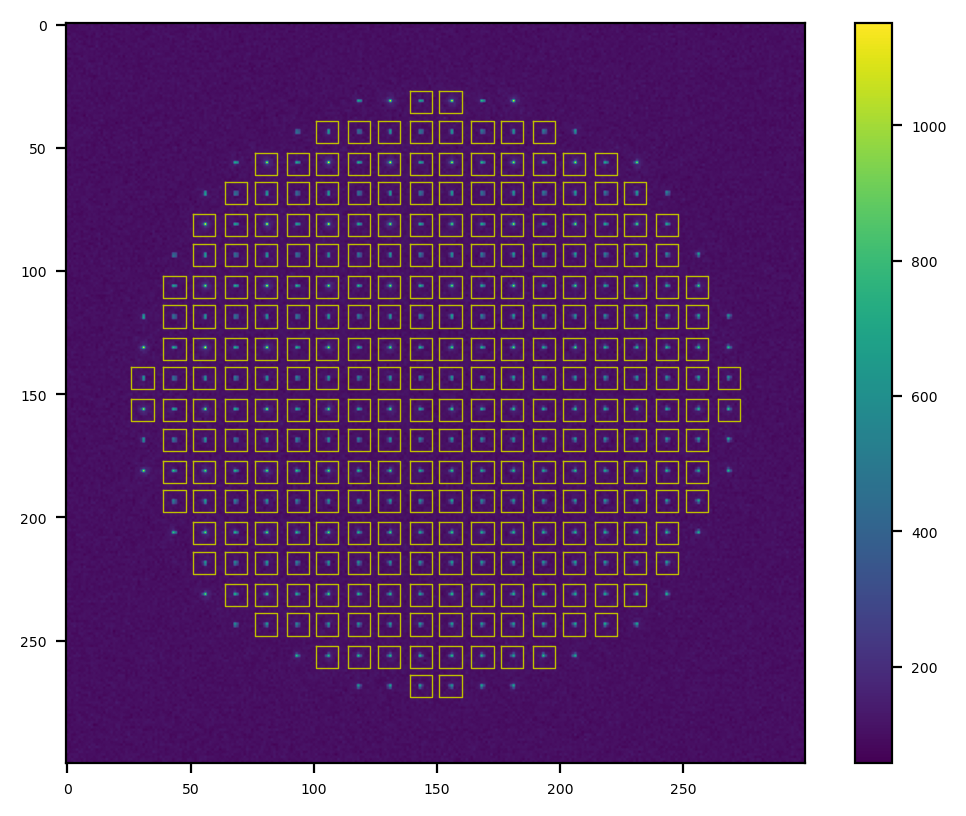

In [6]:
plt.figure(dpi=200)
plt.imshow(cam.get_image())
plt.colorbar()
plt.autoscale(False)
for y1,y2,x1,x2 in zip(sensor.search_boxes.y1,
                       sensor.search_boxes.y2,
                       sensor.search_boxes.x1,
                       sensor.search_boxes.x2):
    plt.plot([x1,x2-1,x2-1,x1,x1],[y1,y1,y2-1,y2-1,y1],'y-',linewidth=.5)

In [ ]:
sensor.sense()

## Centroiding

Now we define the centroiding method explicitly (as opposed to calling CIAO's built-in method). This allows us to see the iterative centroiding algorithm in detail, including the background subtraction step. It also allows us to check the validity of CIAO's output. [CIAO centroiding method](centroid.pyx).

In [ ]:
n_iterations = ccfg.centroiding_iterations
half_width= ccfg.search_box_half_width
iterative_step = ccfg.iterative_centroiding_step



# an explicit background estimation function
# whenever we specify the edges of a region with x1,x2,y1,y2, as
# a convention we mean x2 and y2 to be the final column and row in
# the region, as opposed to the python idiom making them the first
# excluded indices
# IMPORTANT: unlike normal Python idiom, y2-y1 no longer indicates
# the number of rows, but one less than that number.
def estimate_background(spots,x_ref,y_ref,half_width,do_plots=False):
    
    if do_plots:
        plt.figure(dpi=200)
        colors = 'gyrm'*100
    
    # half_width and iterative step should be whole numbers
    assert half_width%1==0
    
    # let's enforce the half width being an integer, so that we
    # keep our array indices x1,x2,y1,y2 as integers as well
    half_width = int(half_width)
    
    # we round the reference coordinates to the nearest integer
    # so that we compute the center of mass over whole pixels;
    # an alternative would be linear interpolation, which would be
    # computationally cheap but the code would become complicated
    # make sure these are ints too
    x,y = int(round(x_ref)),int(round(y_ref))
        
    # now we have the (inclusive) column and row indices, all ints
    x1 = x - half_width
    x2 = x + half_width
    y1 = y - half_width
    y2 = y + half_width
    
    
    # first, survey edges to estimate background
    intensity = np.float64(0.0)
    counter = np.float64(0.0)
    
    for xedge in range(x1,x2+1):
        intensity = intensity + float(spots[y1,xedge]) + float(spots[y2,xedge])
        counter = counter + 2.0
        
    for yedge in range(y1,y2+1):
        intensity = intensity + float(spots[yedge,x1]) + float(spots[yedge,x2])
        counter = counter + 2.0

    background = intensity/counter
    
    return background


# an explicit centroiding function
# whenever we specify the edges of a region with x1,x2,y1,y2, as
# a convention we mean x2 and y2 to be the final column and row in
# the region, as opposed to the python idiom making them the first
# excluded indices
# IMPORTANT: unlike normal Python idiom, y2-y1 no longer indicates
# the number of rows, but one less than that number.
def centroid(spots,x_ref,y_ref,half_width,n_iterations,iterative_step,background,do_plots=False):
    
    if do_plots:
        plt.figure(dpi=200)
        colors = 'gyrm'*100
    
    # half_width and iterative step should be whole numbers
    assert half_width%1==0
    assert iterative_step%1==0
    
    # let's enforce the half width being an integer, so that we
    # keep our array indices x1,x2,y1,y2 as integers as well
    half_width = int(half_width)
    iterative_step = int(iterative_step)
    
    # we round the reference coordinates to the nearest integer
    # so that we compute the center of mass over whole pixels;
    # an alternative would be linear interpolation, which would be
    # computationally cheap but the code would become complicated
    # make sure these are ints too
    x,y = int(round(x_ref)),int(round(y_ref))
            
    for k in range(n_iterations):
        x1 = x - half_width
        x2 = x + half_width
        y1 = y - half_width
        y2 = y + half_width
        
        arr = spots[y1:y2+1,x1:x2+1]-background # again, we need the +1 because of Python exclusive indexing
        
        arr = np.clip(arr,0,np.inf)

        ay,ax = arr.shape
        if k==0:
            # sanity check
            assert ax==ay==half_width*2+1
            
        XX,YY = np.meshgrid(np.arange(ax),np.arange(ay))        
        XX = XX + x - half_width
        YY = YY + y - half_width
        
        # the spots image is an int, but now
        # we need floating point precision, so convert these to
        # floats
        x_cent = np.sum(XX*arr).astype(np.float)/np.sum(arr).astype(np.float)
        y_cent = np.sum(YY*arr).astype(np.float)/np.sum(arr).astype(np.float)
        x,y = int(round(x_cent)),int(round(y_cent))
        half_width = half_width - iterative_step

        if do_plots:

            if k==0:
                plt.imshow(spots,cmap='gray')
                plt.xlim([x1-1.5,x2+1.5])
                plt.ylim([y2+1.5,y1-1.5])
                plt.colorbar()
                
            plt.plot([x1-.5,x2+.5,x2+.5,x1-.5,x1-.5],[y1-.5,y1-.5,y2+.5,y2+.5,y1-.5],'%s-'%colors[k])
            plt.autoscale(False)
            plt.plot(x_cent,y_cent,'%s.'%colors[k])
            
    return x_cent,y_cent
        

### An example of the centroiding process

If we call ```centroid``` with do_plots=True, we'll see the result of the algorithm on a single spot. The green line shows the region used to compute the first iteration, and the yellow line the second iteration. The resulting centroids are plotted as green and yellow dots, respectively.

In [ ]:
idx=29
x_float = sensor.search_boxes.x[idx]
y_float = sensor.search_boxes.y[idx]

background = estimate_background(sensor.cam.image,x_float,y_float,half_width)
x_cent,y_cent = centroid(sensor.cam.image,x_float,y_float,half_width,n_iterations,iterative_step,background,do_plots=True)    

In [ ]:
# Now let's validate CIAO's centroiding by comparing its result with that of our centroiding function
sensor.sense()
x_cent_vec = []
for k_lenslet in range(sensor.n_lenslets):
    x_float = sensor.search_boxes.x[k_lenslet]
    y_float = sensor.search_boxes.y[k_lenslet]
    bg = estimate_background(sensor.cam.image,x_float,y_float,half_width)
    x_cent,y_cent = centroid(sensor.cam.image,x_float,y_float,half_width,n_iterations,iterative_step,bg,do_plots=False)
    #print sensor.box_backgrounds[k_lenslet],bg
    x_cent_vec.append(x_cent)
    
plt.figure(dpi=150)
plt.plot(sensor.x_centroids, x_cent_vec-sensor.x_centroids,'k.')
plt.show()

### Conclusion

The error between our explicit calculations and what CIAO yields is on the order of $10^{-12}$, which is very low. I believe it is due to roundoff errors between C floats and Python floats, but leave it for later investigation.

## Calculation of local wavefront slope from centroids

The next step in the loop is calculation of the wavefront slope from the centers of mass of the spots. Briefly, the reference coordinates are subtracted from the centroids (which are currently expressed in pixels, relative to the reference coordinates), and multiplied by the pixel size to give a physical displacement from reference. This physical displacement is then divided by the focal length of the lenslet to give a slope. This is done for each lenslet, separately for the x and y components of the slope.

To begin with, let's write a convenience method that computes all the slopes using our explicit background estimation and centroiding algorithms.

In [8]:
def get_slopes():
    spots_image = sensor.cam.image
    n_lenslets = sensor.n_lenslets
    half_width = ccfg.search_box_half_width
    n_iterations = ccfg.centroiding_iterations
    iterative_step = ccfg.iterative_centroiding_step
    
    x_ref,y_ref = sensor.search_boxes.x,sensor.search_boxes.y

    x_slope_vec = []
    y_slope_vec = []
    
    for x,y in zip(x_ref,y_ref):
        background = estimate_background(spots_image,x,y,half_width)
        x_cent,y_cent = centroid(spots_image,x,y,half_width,n_iterations,iterative_step,background)
        x_disp,y_disp = x_cent-x,y_cent-y
        x_slope = x_disp*ccfg.pixel_size_m/ccfg.lenslet_focal_length_m
        y_slope = y_disp*ccfg.pixel_size_m/ccfg.lenslet_focal_length_m
        x_slope_vec.append(x_slope)
        y_slope_vec.append(y_slope)
        
        
    return np.array(x_slope_vec),np.array(y_slope_vec)


Sensor sense method
start -> cam.get_image: 67.333 ms
cam.get_image -> image stats: 9.667 ms
image stats -> estimate background: 0.667 ms
estimate background -> centroid: 20.000 ms
centroid -> reconstruct wavefront: 0.000 ms
reconstruct wavefront -> end sense: 0.000 ms

1


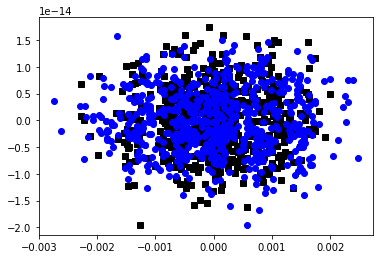

In [9]:
sensor.sense()
x_slopes, y_slopes = get_slopes()

x_slopes = x_slopes - np.mean(x_slopes)
y_slopes = y_slopes - np.mean(y_slopes)

plt.plot(x_slopes,x_slopes-sensor.x_slopes,'ks')
plt.plot(y_slopes,y_slopes-sensor.y_slopes,'bo')
plt.show()


### CIAO centroiding functions, written in Cython, for reference

```python
import numpy as np                                                                                                                                                                                          
cimport numpy as np                                                                                                                                                                                         
from matplotlib import pyplot as plt                                                                                                                                                                        
import cython                                                                                                                                                                                               
from cython.parallel import prange                                                                                                                                                                          
from libc.stdio cimport printf                                                                                                                                                                              
import sys,os                                                                                                                                                                                               
from sys import exit                                                                                                                                                                                        
                                                                                                                                                                                                            
# Importing round is failing in windows for some reason; it may have                                                                                                                                        
# something to do with the MSVS c compiler and a 32-bit 64-bit clash.                                                                                                                                       
# If we want to implement parallelism at some point, we need to figure                                                                                                                                      
# this out, because the python round function cannot be used in a                                                                                                                                           
# 'with nogil:' context (since it's a python object), but we need some                                                                                                                                      
# way to round values and it's risky to write our own c round function                                                                                                                                      
# because it might be inefficient compared to clang's version.                                                                                                                                              
# from libc.math cimport round as c_round                                                                                                                                                                   
                                                                                                                                                                                                            
# Changes required to compile parallel version (Linux only):                                                                                                                                                
# 1. uncomment the "from libc.math cimport round as c_round" line above                                                                                                                                     
# 2. change all calls to round below to c_round                                                                                                                                                             
# 3. add back the 'with nogil:' context, just above the prange                                                                                                                                              
# 4. change range to prange in the outermost loop (the one that iterates                                                                                                                                    
#    over the spots                                                                                                                                                                                         
                                                                                                                                                                                                            
ctypedef np.uint16_t uint16_t                                                                                                                                                                               
                                                                                                                                                                                                            
# Function compute_centroids:                                                                                                                                                                               
# this function takes the following arguments:                                                                                                                                                              
# 1. spots_image (int array): the spots image                                                                                                                                                               
# 2. sb_x_vec (float array): the x coordinates of search box centers                                                                                                                                        
# 3. sb_y_vec (float array): the y coordinates of search box centers                                                                                                                                        
# 4. sb_bg_vec (float array): the background values for each search box                                                                                                                                     
# 5. sb_half_width (integer): if the width of the search box (inclusive),                                                                                                                                   
#    is odd integer N, this is (N-1)//2                                                                                                                                                                     
# 6. iterations (integer): the number of centroid iterations, in                                                                                                                                            
#    which the search boxes are recentered about the                                                                                                                                                        
#    previous center of mass measurement                                                                                                                                                                    
# 7. iteration_step_px (integer): the number of pixels by which                                                                                                                                             
#    to reduce the search box half-width on each iteration                                                                                                                                                  
# 8. x_out (float array): an array in which to store the                                                                                                                                                    
#    resulting x coordinates of centers of mass                                                                                                                                                             
# 9. y_out (float array): an array in which to store the                                                                                                                                                    
#    resulting y coordinates of centers of mass                                                                                                                                                             
# 10. mean_intensity (float array): an array in which to store each                                                                                                                                         
#    search box's mean intensity                                                                                                                                                                            
# 11. maximum_intensity (float array): (ditto)                                                                                                                                                              
# 12. minimum_intensity (float array): (ditto)                                                                                                                                                              
# 13. num_threads (integer): number of threads to use; currently not                                                                                                                                        
#     implemented because it doesn't improve speed. Use of prange may                                                                                                                                       
#     not be optimal way to thread this.                                                                                                                                                                    
                                                                                                                                                                                                            
@cython.boundscheck(False)                                                                                                                                                                                  
@cython.wraparound(False)                                                                                                                                                                                   
cpdef compute_centroids(np.ndarray[np.int16_t,ndim=2] spots_image,                                                                                                                                          
np.ndarray[np.float_t,ndim=1] sb_x_vec,                                                                                                                                                                     
np.ndarray[np.float_t,ndim=1] sb_y_vec,                                                                                                                                                                     
np.ndarray[np.float_t,ndim=1] sb_bg_vec,                                                                                                                                                                    
sb_half_width_p,                                                                                                                                                                                            
iterations_p,                                                                                                                                                                                               
iteration_step_px_p,                                                                                                                                                                                        
np.ndarray[np.float_t,ndim=1] x_out,                                                                                                                                                                        
np.ndarray[np.float_t,ndim=1] y_out,                                                                                                                                                                        
np.ndarray[np.float_t,ndim=1] mean_intensity,                                                                                                                                                               
np.ndarray[np.float_t,ndim=1] maximum_intensity,                                                                                                                                                            
np.ndarray[np.float_t,ndim=1] minimum_intensity,                                                                                                                                                            
num_threads_p = 1):                                                                                                                                                                                         
                                                                                                                                                                                                            
                                                                                                                                                                                                            
cdef np.int_t n_spots = len(sb_x_vec)                                                                                                                                                                       
cdef np.int_t num_threads = int(num_threads_p)                                                                                                                                                              
cdef np.int_t iterations = int(iterations_p)                                                                                                                                                                
cdef np.int_t iteration_step_px = int(iteration_step_px_p)                                                                                                                                                  
cdef np.int_t sb_half_width = int(sb_half_width_p)                                                                                                                                                          
                                                                                                                                                                                                            
cdef np.float_t intensity                                                                                                                                                                                   
cdef np.float_t background                                                                                                                                                                                  
cdef np.float_t xprod                                                                                                                                                                                       
cdef np.float_t yprod                                                                                                                                                                                       
cdef np.int_t x                                                                                                                                                                                             
cdef np.int_t x1                                                                                                                                                                                            
cdef np.int_t x2                                                                                                                                                                                            
cdef np.int_t y                                                                                                                                                                                             
cdef np.int_t y1                                                                                                                                                                                            
cdef np.int_t y2                                                                                                                                                                                            
cdef np.int_t sy                                                                                                                                                                                            
cdef np.int_t sx                                                                                                                                                                                            
cdef np.int_t half_width                                                                                                                                                                                    
cdef np.float_t imax                                                                                                                                                                                        
cdef np.float_t imin                                                                                                                                                                                        
cdef np.float_t pixel                                                                                                                                                                                       
cdef np.float_t counter                                                                                                                                                                                     
cdef np.int_t k_iteration                                                                                                                                                                                   
cdef np.int_t k_spot                                                                                                                                                                                        
                                                                                                                                                                                                            
sy = spots_image.shape[0]                                                                                                                                                                                   
sx = spots_image.shape[1]                                                                                                                                                                                   
                                                                                                                                                                                                            
# Populate x_out,y_out with the sb centers, for starters; this allows                                                                                                                                       
# us to use the out arrays as places to both read the current sb center                                                                                                                                     
# (in the case of multiple iterations, where we want to recenter the                                                                                                                                        
# sb on each iteration                                                                                                                                                                                      
# This serves an additional purpose--preventing sb_x_vec or sb_y_vec from                                                                                                                                   
# being altered; this is critical, as these represent the loop's search box                                                                                                                                 
# centers and reference coordinates.                                                                                                                                                                        
x_out[:] = sb_x_vec[:]                                                                                                                                                                                      
y_out[:] = sb_y_vec[:]                                                                                                                                                                                      
                                                                                                                                                                                                            
# first, we iterate through the number of iterations                                                                                                                                                        
for k_iteration in range(0,iterations):                                                                                                                                                                     
                                                                                                                                                                                                            
for k_spot in range(n_spots):                                                                                                                                                                               
                                                                                                                                                                                                            
imin = 2**15                                                                                                                                                                                                
imax = -2**15                                                                                                                                                                                               
xprod = 0.0                                                                                                                                                                                                 
yprod = 0.0                                                                                                                                                                                                 
intensity = 0.0                                                                                                                                                                                             
counter = 0.0                                                                                                                                                                                               
                                                                                                                                                                                                            
x1 = int(round(x_out[k_spot]))-sb_half_width+k_iteration*iteration_step_px                                                                                                                                  
x2 = int(round(x_out[k_spot]))+sb_half_width-k_iteration*iteration_step_px                                                                                                                                  
y1 = int(round(y_out[k_spot]))-sb_half_width+k_iteration*iteration_step_px                                                                                                                                  
y2 = int(round(y_out[k_spot]))+sb_half_width-k_iteration*iteration_step_px                                                                                                                                  
                                                                                                                                                                                                            
if x1<0 or x2>sx-1 or y1<0 or y2>sy-1:                                                                                                                                                                      
printf("Search box x=(%ld,%ld),y=(%ld,%ld) extends beyond image edge. Possibly search box width too large.\n",x1,x2,y1,y2)                                                                                  
#exit(0)                                                                                                                                                                                                    
                                                                                                                                                                                                            
if x1>=x2 or y1>=y2:                                                                                                                                                                                        
printf("Search box x=(%ld,%ld),y=(%ld,%ld) too small. Possibly search box width too large, number of iterations too high, or iteration step size too high.\n",x1,x2,y1,y2)                                  
#exit(0)                                                                                                                                                                                                    
                                                                                                                                                                                                            
background = sb_bg_vec[k_spot]                                                                                                                                                                              
#printf("background=%0.1f\n",background)                                                                                                                                                                    
                                                                                                                                                                                                            
for x in range(x1,x2+1):                                                                                                                                                                                    
for y in range(y1,y2+1):                                                                                                                                                                                    
                                                                                                                                                                                                            
# not sure if it's better to cast with python's float()                                                                                                                                                     
# or c's <float>:                                                                                                                                                                                           
pixel = float(spots_image[y,x])-background                                                                                                                                                                  
                                                                                                                                                                                                            
if pixel<0.0:                                                                                                                                                                                               
pixel = 0.0                                                                                                                                                                                                 
xprod = xprod + pixel*x                                                                                                                                                                                     
yprod = yprod + pixel*y                                                                                                                                                                                     
intensity = intensity + pixel                                                                                                                                                                               
if pixel<imin:                                                                                                                                                                                              
imin = pixel                                                                                                                                                                                                
elif pixel>imax:                                                                                                                                                                                            
imax = pixel                                                                                                                                                                                                
counter = counter + 1.0                                                                                                                                                                                     
                                                                                                                                                                                                            
if intensity==0 or xprod==0 or yprod==0:                                                                                                                                                                    
printf("Warning: search box intensity low; skipping.\n")                                                                                                                                                    
continue                                                                                                                                                                                                    
                                                                                                                                                                                                            
mean_intensity[k_spot] = intensity/counter                                                                                                                                                                  
maximum_intensity[k_spot] = imax                                                                                                                                                                            
minimum_intensity[k_spot] = imin                                                                                                                                                                            
x_out[k_spot] = xprod/intensity                                                                                                                                                                             
y_out[k_spot] = yprod/intensity                                                                                                                                                                             
                                                                                                                                                                                                            
                                                                                                                                                                                                            
# Function estimate_backgrounds:                                                                                                                                                                            
# this function takes the following arguments:                                                                                                                                                              
# 1. spots_image (int array): the spots image                                                                                                                                                               
# 2. sb_x_vec (float array): the x coordinates of search box centers                                                                                                                                        
# 3. sb_y_vec (float array): the y coordinates of search box centers                                                                                                                                        
# 4. sb_bg_vec (float array): array for writing output                                                                                                                                                      
# 5. sb_half_width (integer): if the width of the search box (inclusive)                                                                                                                                    
#    is odd integer N, this is (N-1)//2                                                                                                                                                                     
                                                                                                                                                                                                            
@cython.boundscheck(False)                                                                                                                                                                                  
@cython.wraparound(False)                                                                                                                                                                                   
cpdef estimate_backgrounds(np.ndarray[np.int16_t,ndim=2] spots_image,                                                                                                                                       
np.ndarray[np.float_t,ndim=1] sb_x_vec,                                                                                                                                                                     
np.ndarray[np.float_t,ndim=1] sb_y_vec,                                                                                                                                                                     
np.ndarray[np.float_t,ndim=1] sb_bg_vec,                                                                                                                                                                    
sb_half_width_p):                                                                                                                                                                                           
                                                                                                                                                                                                            
cdef np.int_t n_spots = len(sb_x_vec)                                                                                                                                                                       
cdef np.int_t sb_half_width = int(sb_half_width_p)                                                                                                                                                          
                                                                                                                                                                                                            
cdef np.float_t intensity                                                                                                                                                                                   
cdef np.int_t x                                                                                                                                                                                             
cdef np.int_t x1                                                                                                                                                                                            
cdef np.int_t x2                                                                                                                                                                                            
cdef np.int_t y                                                                                                                                                                                             
cdef np.int_t y1                                                                                                                                                                                            
cdef np.int_t y2                                                                                                                                                                                            
cdef np.int_t sy                                                                                                                                                                                            
cdef np.int_t sx                                                                                                                                                                                            
cdef np.float_t counter                                                                                                                                                                                     
cdef np.int_t k_spot                                                                                                                                                                                        
                                                                                                                                                                                                            
sy = spots_image.shape[0]                                                                                                                                                                                   
sx = spots_image.shape[1]                                                                                                                                                                                   
                                                                                                                                                                                                            
# first, we iterate through the number of iterations                                                                                                                                                        
for k_spot in range(n_spots):                                                                                                                                                                               
                                                                                                                                                                                                            
intensity = 0.0                                                                                                                                                                                             
counter = 0.0                                                                                                                                                                                               
                                                                                                                                                                                                            
x1 = int(round(sb_x_vec[k_spot]))-sb_half_width                                                                                                                                                             
x2 = int(round(sb_x_vec[k_spot]))+sb_half_width                                                                                                                                                             
y1 = int(round(sb_y_vec[k_spot]))-sb_half_width                                                                                                                                                             
y2 = int(round(sb_y_vec[k_spot]))+sb_half_width                                                                                                                                                             
                                                                                                                                                                                                            
if x1<0 or x2>sx-1 or y1<0 or y2>sy-1:                                                                                                                                                                      
printf("Search box x=(%ld,%ld),y=(%ld,%ld) extends beyond image edge. Possibly search box width too large.\n",x1,x2,y1,y2)                                                                                  
exit(0)                                                                                                                                                                                                     
                                                                                                                                                                                                            
if x1>=x2 or y1>=y2:                                                                                                                                                                                        
printf("Search box x=(%ld,%ld),y=(%ld,%ld) too small. Possibly search box width too large, number of iterations too high, or iteration step size too high.\n",x1,x2,y1,y2)                                  
exit(0)                                                                                                                                                                                                     
                                                                                                                                                                                                            
for x in range(x1,x2+1):                                                                                                                                                                                    
intensity = intensity + float(spots_image[y1,x]) + float(spots_image[y2,x])                                                                                                                                 
counter = counter + 2.0                                                                                                                                                                                     
for y in range(y1,y2+1):                                                                                                                                                                                    
intensity = intensity + float(spots_image[y,x1]) + float(spots_image[y,x2])                                                                                                                                 
counter = counter + 2.0                                                                                                                                                                                     
                                                                                                                                                                                                            
sb_bg_vec[k_spot] = intensity/counter                                                                                                                                                                       
                                                                                                                                                                                                            
                                                                                                                                                                                                            
                                                                                                                                                                                                            
@cython.boundscheck(False)                                                                                                                                                                                  
@cython.wraparound(False)                                                                                                                                                                                   
cpdef fast_centroids(np.ndarray[np.int16_t,ndim=2] spots_image,                                                                                                                                             
np.ndarray[np.float_t,ndim=1] sb_x_vec,                                                                                                                                                                     
np.ndarray[np.float_t,ndim=1] sb_y_vec,                                                                                                                                                                     
sb_half_width_p,                                                                                                                                                                                            
centroiding_half_width_p,                                                                                                                                                                                   
np.ndarray[np.float_t,ndim=1] x_out,                                                                                                                                                                        
np.ndarray[np.float_t,ndim=1] y_out,                                                                                                                                                                        
np.ndarray[np.float_t,ndim=1] sb_max_vec,                                                                                                                                                                   
np.ndarray[np.int16_t,ndim=1] valid_vec,                                                                                                                                                                    
verbose_p = 0,                                                                                                                                                                                              
num_threads_p = 1):                                                                                                                                                                                         
                                                                                                                                                                                                            
"""Function fast_centroids:                                                                                                                                                                                 
this function takes the following arguments:                                                                                                                                                                
1. spots_image (int array): the spots image                                                                                                                                                                 
2. sb_x_vec (float array): the x coordinates of search box centers                                                                                                                                          
3. sb_y_vec (float array): the y coordinates of search box centers                                                                                                                                          
4. sb_half_width_p (integer): if the width of the search box (inclusive)                                                                                                                                    
is odd integer N, this is (N-1)//2                                                                                                                                                                          
5. centroiding_half_width_p: this is the width of the region over which                                                                                                                                     
to compute the center of mass; should be at least twice the expected                                                                                                                                        
subaperture diffraction-limited spot size (to handle elongation of spots                                                                                                                                    
due to axial distribution of retinal reflectors)                                                                                                                                                            
6. x_out (float array): an array in which to store the                                                                                                                                                      
resulting x coordinates of centers of mass                                                                                                                                                                  
7. y_out (float array): an array in which to store the                                                                                                                                                      
resulting y coordinates of centers of mass                                                                                                                                                                  
8. maximum_intensity (float array): (ditto)                                                                                                                                                                 
9. valid_vec (int array): a numpy array with type int16 into which                                                                                                                                          
the validity of a centroid is recorded; on output 0 means the                                                                                                                                               
measurement was invalid, and 1 means valid                                                                                                                                                                  
10. verbose (integer): determines verbosity of debugging messages                                                                                                                                           
11. num_threads (integer): number of threads to use; currently not                                                                                                                                          
implemented."""                                                                                                                                                                                             
                                                                                                                                                                                                            
cdef int sy                                                                                                                                                                                                 
cdef int sx                                                                                                                                                                                                 
                                                                                                                                                                                                            
sy = spots_image.shape[0]                                                                                                                                                                                   
sx = spots_image.shape[1]                                                                                                                                                                                   
                                                                                                                                                                                                            
# expose memory location of all numpy arrays using typed memoryviews                                                                                                                                        
# this improves speed because it removes numpy overhead, and more                                                                                                                                           
# importantly it's required for parallelism because we need to put                                                                                                                                          
# prange in a 'with nogil:' context                                                                                                                                                                         
cdef short [:,:] spots_image_view = spots_image                                                                                                                                                             
cdef double [:] sb_x_vec_view = sb_x_vec                                                                                                                                                                    
cdef double [:] sb_y_vec_view = sb_y_vec                                                                                                                                                                    
cdef double [:] x_out_view = x_out                                                                                                                                                                          
cdef double [:] y_out_view = y_out                                                                                                                                                                          
cdef double [:] sb_max_vec_view = sb_max_vec                                                                                                                                                                
cdef short [:] valid_vec_view = valid_vec                                                                                                                                                                   
                                                                                                                                                                                                            
cdef int n_spots = len(sb_x_vec)                                                                                                                                                                            
cdef int spot_index                                                                                                                                                                                         
cdef int sb_half_width_c = sb_half_width_p                                                                                                                                                                  
cdef int centroiding_half_width_c = centroiding_half_width_p                                                                                                                                                
cdef int verbose_c = verbose_p                                                                                                                                                                              
                                                                                                                                                                                                            
# declare some variables for the inner loops; don't forget to initialize                                                                                                                                    
# on every iteration                                                                                                                                                                                        
cdef int y                                                                                                                                                                                                  
cdef int x                                                                                                                                                                                                  
cdef int max_y                                                                                                                                                                                              
cdef int max_x                                                                                                                                                                                              
cdef int current_max                                                                                                                                                                                        
cdef short pixel                                                                                                                                                                                            
                                                                                                                                                                                                            
cdef int x1                                                                                                                                                                                                 
cdef int x2                                                                                                                                                                                                 
cdef int y1                                                                                                                                                                                                 
cdef int y2                                                                                                                                                                                                 
                                                                                                                                                                                                            
cdef double xnum                                                                                                                                                                                            
cdef double ynum                                                                                                                                                                                            
cdef double denom                                                                                                                                                                                           
                                                                                                                                                                                                            
# first we have to iterate through the spots; do this without the gil, for                                                                                                                                  
# future parallelization                                                                                                                                                                                    
#with nogil:                                                                                                                                                                                                
# changed this for the time being to prevent linking errors in windows due                                                                                                                                  
# to 32-bit libc.math.round being incompatile with 64 bit python. Replacing                                                                                                                                 
# 'with nogil:' with 'if True:' to avoid having to unindent everything after.                                                                                                                               
if True:                                                                                                                                                                                                    
# For parallel version change range to prange                                                                                                                                                               
for spot_index in range(n_spots):                                                                                                                                                                           
current_max = -2**16+1                                                                                                                                                                                      
                                                                                                                                                                                                            
# This is how we have to do it if we want nogil and parallelism:                                                                                                                                            
#x1 = <int>c_round(sb_x_vec_view[spot_index]-sb_half_width_c)                                                                                                                                               
#x2 = <int>c_round(sb_x_vec_view[spot_index]+sb_half_width_c)                                                                                                                                               
#y1 = <int>c_round(sb_y_vec_view[spot_index]-sb_half_width_c)                                                                                                                                               
#y2 = <int>c_round(sb_y_vec_view[spot_index]+sb_half_width_c)                                                                                                                                               
                                                                                                                                                                                                            
# This is how we do it (with Python round) to avoid the Windows                                                                                                                                             
# problem but this prevents parallelizing:                                                                                                                                                                  
x1 = <int>round(sb_x_vec_view[spot_index]-sb_half_width_c)                                                                                                                                                  
x2 = <int>round(sb_x_vec_view[spot_index]+sb_half_width_c)                                                                                                                                                  
y1 = <int>round(sb_y_vec_view[spot_index]-sb_half_width_c)                                                                                                                                                  
y2 = <int>round(sb_y_vec_view[spot_index]+sb_half_width_c)                                                                                                                                                  
                                                                                                                                                                                                            
if verbose_c>0:                                                                                                                                                                                             
printf('cython A %d,%d,%d,%d,%d\n',spot_index,x1,x2,y1,y2)                                                                                                                                                  
                                                                                                                                                                                                            
if (x1<0 or x2<0 or x1>sx-1 or x2>sx-1 or                                                                                                                                                                   
y1<0 or y2<0 or y1>sy-1 or y2>sy-1):                                                                                                                                                                        
printf('centroid.fast_centroids: search box coordinates x=[%d,%d], y=[%d,%d] not valid for spots image with size %dx%d. Check search_box_half_width.\n',x1,x2,y1,y2,sx,sy)                                  
valid_vec_view[spot_index] = 0                                                                                                                                                                              
x_out[spot_index] = -1                                                                                                                                                                                      
y_out[spot_index] = -1                                                                                                                                                                                      
break                                                                                                                                                                                                       
                                                                                                                                                                                                            
for y in range(y1,y2+1):                                                                                                                                                                                    
for x in range(x1,x2+1):                                                                                                                                                                                    
pixel = spots_image_view[y,x]                                                                                                                                                                               
if pixel>current_max:                                                                                                                                                                                       
current_max = pixel                                                                                                                                                                                         
max_y = y                                                                                                                                                                                                   
max_x = x                                                                                                                                                                                                   
                                                                                                                                                                                                            
sb_max_vec[spot_index] = current_max                                                                                                                                                                        
                                                                                                                                                                                                            
# See note abouve about c_round vs round                                                                                                                                                                    
# x1 = <int>c_round(max_x-centroiding_half_width_c)                                                                                                                                                         
# x2 = <int>c_round(max_x+centroiding_half_width_c)                                                                                                                                                         
# y1 = <int>c_round(max_y-centroiding_half_width_c)                                                                                                                                                         
# y2 = <int>c_round(max_y+centroiding_half_width_c)                                                                                                                                                         
                                                                                                                                                                                                            
# Using Python round instead of libc.math.round for                                                                                                                                                         
# windows compatibility                                                                                                                                                                                     
x1 = <int>round(max_x-centroiding_half_width_c)                                                                                                                                                             
x2 = <int>round(max_x+centroiding_half_width_c)                                                                                                                                                             
y1 = <int>round(max_y-centroiding_half_width_c)                                                                                                                                                             
y2 = <int>round(max_y+centroiding_half_width_c)                                                                                                                                                             
                                                                                                                                                                                                            
if verbose_c>0:                                                                                                                                                                                             
printf('cython B %d,%d,%d,%d,%d\n',spot_index,x1,x2,y1,y2)                                                                                                                                                  
                                                                                                                                                                                                            
if (x1<0 or x2<0 or x1>sx-1 or x2>sx-1 or                                                                                                                                                                   
y1<0 or y2<0 or y1>sy-1 or y2>sy-1):                                                                                                                                                                        
printf('centroid.fast_centroids: centroiding coordinates x=[%d,%d], y=[%d,%d] not valid for spots image with size %dx%d. Check centroiding_half_width.\n',x1,x2,y1,y2,sx,sy)                                
valid_vec_view[spot_index] = 0                                                                                                                                                                              
x_out[spot_index] = -1                                                                                                                                                                                      
y_out[spot_index] = -1                                                                                                                                                                                      
else:                                                                                                                                                                                                       
                                                                                                                                                                                                            
xnum = 0.0                                                                                                                                                                                                  
ynum = 0.0                                                                                                                                                                                                  
denom = 0.0                                                                                                                                                                                                 
                                                                                                                                                                                                            
#printf('box %d x=[%d,%d] y=[%d,%d]\n',spot_index,x1,x2,y1,y2)                                                                                                                                              
for y in range(y1,y2+1):                                                                                                                                                                                    
for x in range(x1,x2+1):                                                                                                                                                                                    
pixel = spots_image_view[y,x]                                                                                                                                                                               
xnum = xnum + <double>(pixel*x)                                                                                                                                                                             
ynum = ynum + <double>(pixel*y)                                                                                                                                                                             
denom = denom + <double>pixel                                                                                                                                                                               
#printf('\t%d,%d,%0.2f,%0.2f,%0.2f\n',x,y,xnum,ynum,denom)                                                                                                                                                  
                                                                                                                                                                                                            
if denom>0:                                                                                                                                                                                                 
#printf('%f,%f,%f,\n',xnum,ynum,denom)                                                                                                                                                                      
x_out[spot_index] = xnum/denom                                                                                                                                                                              
y_out[spot_index] = ynum/denom                                                                                                                                                                              
#printf('%f,%f\n',x_out[spot_index],y_out[spot_index])                                                                                                                                                      
#printf('\n')                                                                                                                                                                                               
valid_vec[spot_index] = 1                                                                                                                                                                                   
else:                                                                                                                                                                                                       
printf('centroid.fast_centroids: centroiding coordinates x=[%d,%d], y=[%d,%d] produce search box with zero intensity. Check image.\n',x1,x2,y1,y2,sx,sy)                                                    
valid_vec[spot_index] = 0                                                                                                                                                                                   
x_out[spot_index] = -1                                                                                                                                                                                      
y_out[spot_index] = -1                                                                                                                                                                                      
                                                                                                                                                                                                            
                                                                                                                                                                                                            
return 1                                                                                                                                                                                                    
```